нужно добиться результата чтобы RMSE<=1500

все по этапам
- посмотреть на пропуски и заполнить их разными способами (на графике можно визуально проверить какой вариант будет лучше, тк не все методы тут хорошо подойдут, плюс по метрикам будет тоже видно)
- проверка временного ряда на стационарность
- выбор модели, тюнинг (различные параметры p,d,q, также можно попробовать модель с сезонностью)

помимо моделей из лекции можно использовать lstm, prophet, бустинги (если будет желание)

у меня получилось RMSE в одной из модели ±1000

если RMSE<=1500  это 100 баллов
за каждые 10% от 1500 будут хуже баллы

rmse 1750 - баллов будет 90
rmse 1900 - баллов будет 80
и тд


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer

In [3]:
df = pd.read_csv('home_date_miss_values.csv', sep=';')
df['date'] = pd.to_datetime(df['date'])
df = df[df.date > pd.to_datetime('2022-05-30')]
df

,date,value
731,2022-05-31,31183.7
732,2022-06-01,29328.6
733,2022-06-02,29572.8
734,2022-06-03,29255.0
735,2022-06-04,29450.1
...,...,...
1091,2023-05-26,26338.0
1092,2023-05-27,26554.8
1093,2023-05-28,26788.7
1094,2023-05-29,27550.0


EDA

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 731 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   value   353 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [5]:
df.describe()

,value
count,353.000000
mean,21839.537677
std,4040.851138
min,15470.500000
25%,18937.300000
50%,20957.000000
75%,24210.800000
max,31183.700000


In [6]:
df.value

731     31183.7
732     29328.6
733     29572.8
734     29255.0
735     29450.1
         ...   
1091    26338.0
1092    26554.8
1093    26788.7
1094    27550.0
1095    27559.8
Name: value, Length: 365, dtype: float64

In [10]:
df = df.ffill()
df

,date,value
731,2022-05-31,31183.7
732,2022-06-01,29328.6
733,2022-06-02,29572.8
734,2022-06-03,29255.0
735,2022-06-04,29450.1
...,...,...
1091,2023-05-26,26338.0
1092,2023-05-27,26554.8
1093,2023-05-28,26788.7
1094,2023-05-29,27550.0


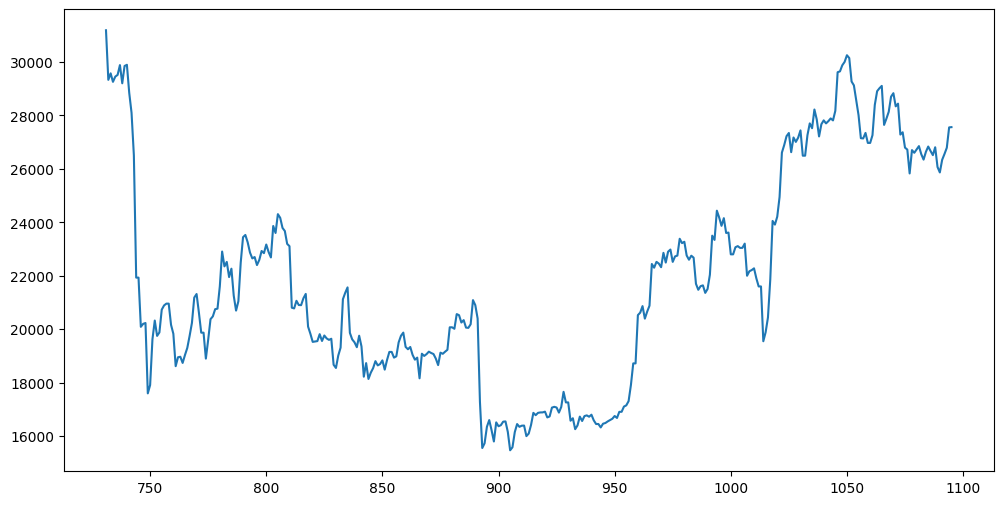

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['value'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 365 entries, 731 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    365 non-null    datetime64[ns]
 1   value   365 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [13]:
train_df = df[df.date < pd.to_datetime('2023-05-01')]
test_df = df[df.date >= pd.to_datetime('2023-05-01')]
print(train_df.shape)
print(test_df.shape)

(335, 2)
(30, 2)


In [14]:
#стационарность
result = adfuller(df['value'])

print('ADF Statistic:', result[0])
print('p-value:', result[1]) # p-value > 0.05
print('Critical Values:', result[4]) # Critical Values < ADF Statistic

ADF Statistic: -1.9621771140607267
p-value: 0.30339926847508036
Critical Values: {'1%': -3.448493650810824, '5%': -2.8695352280356556, '10%': -2.5710293341377715}


In [88]:
AR = ARIMA(train_df.value.values, order=(5,0,15)) # rmse = 760 
#SARIMAX(train_df.value.values, order=(4,1,20), seasonal= (1,1,1,1)) # rmse = 1900
#AutoReg(train_df.value.values, lags=11) # rmse = 970
AR_model = AR.fit()

In [89]:
AR_model.predict(start=len(train_df),
                 end=len(train_df) + len(test_df)-1)

array([28620.93356347, 28635.84103845, 28470.65602116, 28094.992165  ,
       28005.68310245, 27973.04896089, 27868.02188797, 27847.1826825 ,
       28130.80400391, 28186.58224424, 28237.68113268, 28426.89703593,
       28261.94484906, 28027.33184383, 27922.5669032 , 27589.63599064,
       27220.10096848, 27066.43479402, 26835.94231131, 26602.24750049,
       26601.327419  , 26582.57975771, 26516.53376709, 26607.89003283,
       26664.46227776, 26604.67981664, 26618.55149893, 26592.87278786,
       26435.35502162, 26324.78075496])

In [90]:
test_df['AR_model_prediction'] = AR_model.predict(start =len(train_df),
                                                  end= len(train_df) + len(test_df)-1)

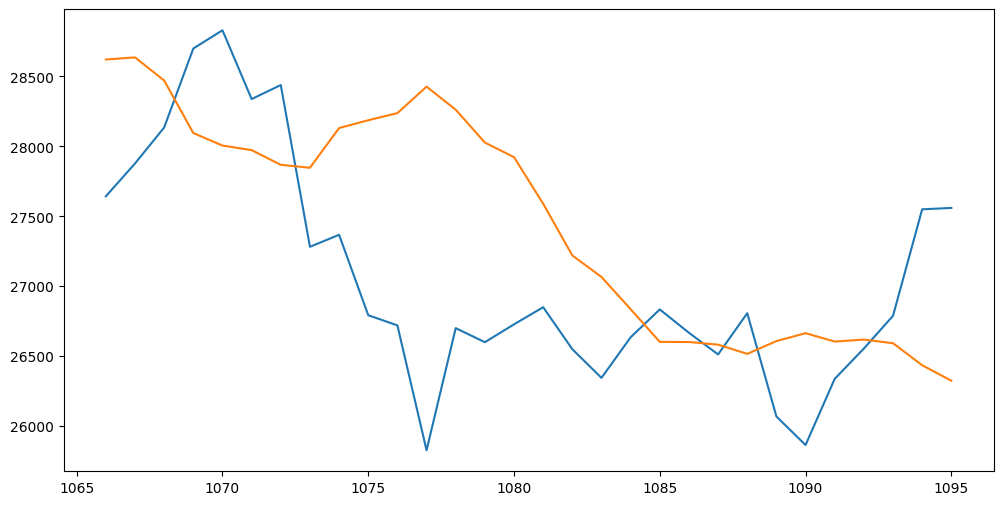

In [91]:
plt.figure(figsize=(12, 6))
plt.plot(test_df[['value', 'AR_model_prediction']])

In [92]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print('MAE: ', mean_absolute_error(test_df['value'],
                                            test_df['AR_model_prediction']))

print('RMSE: ', mean_squared_error(test_df['value'],
                                            test_df['AR_model_prediction'])**0.5)

MAE:  755.4211799807373
RMSE:  939.2985334497606


Итоговый RMSE<=1500